# Chapter 10 케라스를 사용한 인공 신경망 소개

In [1]:
# 기본설정

# 파이썬 버전 확인
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 버전 확인
import sklearn
assert sklearn.__version__ >= "0.20"

# 공동 모듈 임포트
import numpy as np
import os

# 그래프 출력 설정
%matplotlib inline
# 위에꺼는 구버전에서 설정해야 되는거였음 설정안해도됨
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ho_chap_10"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)   # exist_ok=True 폴더가 없으면 생성

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()  # 입력없이 사용할 경우 기존에 세팅된 기본값으로 자동 레이아웃 설정
    plt.savefig(path, format=fig_extension, dpi=resolution)  # dpi값 설정을 통해 고해상도 그래프 그리기 가능

### 10.1.3 퍼셉트론

In [4]:
# 퍼셉트론
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2,3)] # 꽃잎의 길이와 너비
y = (iris.target == 0).astype(np.int)  # 부채붓꽃(iris Setosa)인가?

per_clf = Perceptron()
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [5]:
y_pred

array([0])

그림 저장: perceptron_iris_plot


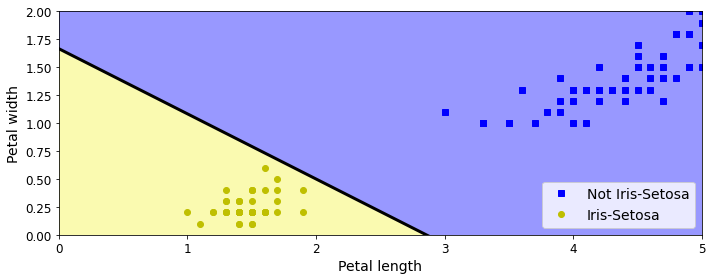

In [6]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

## 10.2 케라스로 다층 퍼셉트론 구현하기

In [7]:
# 모듈 임포트
import tensorflow as tf
from tensorflow import keras

print(f"tensorflow ver : {tf.__version__}, keras ver : {keras.__version__}")

tensorflow ver : 2.6.0, keras ver : 2.6.0


### 10.2.2 시퀀셜 API를 사용하여 이미지 분류기 만들기

데이터셋 적재하기

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


사이킷런과는 다르게 28x28 크기의 배열로 되어있고 정수값으로 표현되어있음

In [9]:
X_train_full.shape

(60000, 28, 28)

In [10]:
X_train_full.dtype

dtype('uint8')

검증세트 나누고 간단한 전처리

In [11]:
X_val, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_val, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.0

보기좋게 클래스 이름 리스트 만들기

In [12]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [13]:
class_names[y_train[0]]

'Coat'

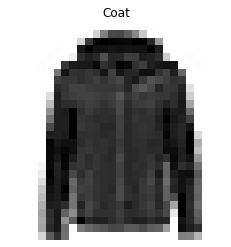

In [15]:
plt.imshow(X_train[0], cmap='gray_r')
plt.axis('off')
plt.title(class_names[y_train[0]])
plt.show()

그림 저장: fashion_mnist_plot


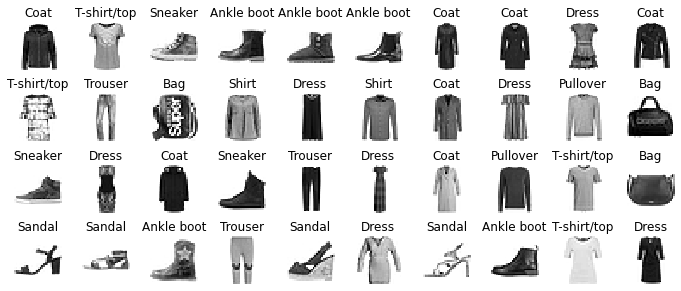

In [16]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

두 개의 은닉층으로 이루어진 분류용 다층 퍼셉트론

In [18]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

리스트로 한번에 전달도 가능

In [19]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


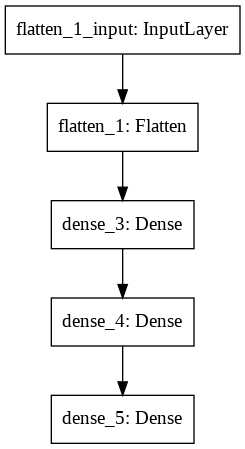

In [22]:
keras.utils.plot_model(model)

모델의 층의 리스트를 출력하거나 인덱스로 층을 쉽게 선택가능. 이름으로도 가능

In [23]:
model.layers

In [25]:
hidden1 = model.layers[1]
hidden1.name

'dense_3'

In [26]:
model.get_layer('dense_3') is hidden1

True

층의 파라미터에 접근
* get_weights, set_weights

In [28]:
weights, biases = hidden1.get_weights()
print(weights)
print(weights.shape)

[[ 0.02028063  0.00311099  0.0106412  ...  0.05619296  0.06294131
   0.01105696]
 [-0.02231183  0.03227018  0.00142422 ...  0.03665423  0.05555885
  -0.01932924]
 [ 0.01029805  0.06975855 -0.01380653 ...  0.04077256  0.00292934
   0.04012084]
 ...
 [-0.04109027  0.04923691 -0.04630665 ...  0.00551988  0.03999264
  -0.06277767]
 [ 0.04149239 -0.043562   -0.00751697 ... -0.05015212 -0.03525118
   0.00453213]
 [-0.01132245 -0.04277583  0.00954619 ...  0.00836945  0.03861325
   0.00796969]]
(784, 300)


In [29]:
print(biases)
print(biases.shape)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(300,)


모델 컴파일

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

모델 훈련과 평가

In [33]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_val, y_val))

Epoch 1/30
1719/1719 [==============================] - 5s 2ms/step - loss: 0.7211 - accuracy: 0.7609 - val_loss: 0.5312 - val_accuracy: 0.8174
Epoch 2/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4904 - accuracy: 0.8286 - val_loss: 0.4803 - val_accuracy: 0.8294
Epoch 3/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4446 - accuracy: 0.8437 - val_loss: 0.4116 - val_accuracy: 0.8584
Epoch 4/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4162 - accuracy: 0.8538 - val_loss: 0.3976 - val_accuracy: 0.8654
Epoch 5/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3956 - accuracy: 0.8609 - val_loss: 0.3967 - val_accuracy: 0.8598
Epoch 6/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3793 - accuracy: 0.8658 - val_loss: 0.3702 - val_accuracy: 0.8716
Epoch 7/30
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3653 - accuracy: 0.8706 - val_loss: 0.3669 - val_accuracy:

validation_split 매개변수를 통해 검증세트를 수동으로 나눌 필요없이도 만들수도 있음

class_weight 나 sample_weight 매개변수로 가중치부여가능

학습곡선

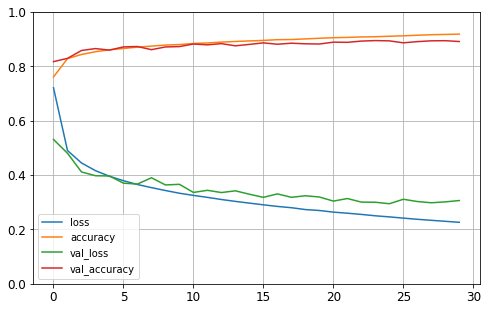

In [35]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)  # 수직축의 범위를 [0-1] 사이로 설정
plt.show()

훈련 곡선을 볼 때 왼쪽으로 에포크의 절반만큼 이동해서 생각

모델 성능이 만족스럽지 않을때
* 학습률 확인 -> optim 변경 -> 층 개수, 층의 뉴런 개수, 은닉층이 사용하는 활성화 함수, 배치 크기

모델 평가 (일반화 오차 추정)

In [36]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3323 - accuracy: 0.8819


[0.3323347270488739, 0.8819000124931335]

모델을 사용해 예측 만들기

In [38]:
# 모든 클래스에 대한 확률
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [42]:
# 예측 클래스만
y_pred = np.argmax(y_proba, axis=1)
y_pred

array([9, 2, 1])

In [43]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [45]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

### 10.2.3 시퀀셜 API를 사용하여 회귀용 다층 퍼셉트론 만들기

In [46]:
# 데이터 불러오기
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

회귀모델 만들기

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]  # 새로운 샘플이라 생각해
y_pred = model.predict(X_new)

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 0.8269 - val_loss: 1.8259
Epoch 2/20
363/363 [==============================] - 0s 986us/step - loss: 3.0579 - val_loss: 0.4954
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4760 - val_loss: 0.5187
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4555 - val_loss: 0.4749
Epoch 5/20
363/363 [==============================] - 0s 992us/step - loss: 0.4380 - val_loss: 0.4436
Epoch 6/20
363/363 [==============================] - 0s 924us/step - loss: 0.4279 - val_loss: 0.4328
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4176 - val_loss: 0.4286
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4129 - val_loss: 0.4334
Epoch 9/20
363/363 [==============================] - 0s 927us/step - loss: 0.4138 - val_loss: 0.4204
Epoch 10/20
363/363 [==============================] - 0s 944us/step - loss: 0.4176 - val_lo